In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

### Analyzing Y

In [135]:
init_X = pd.read_csv('../all_normalized_accuracy_with_pipelineID.csv')

#average_performance = init_X.mean(axis=1)
#max_performance = init_X.max(axis=1)
#min_performance = init_X.min(axis=1)
median_performance = init_X.median(axis=1)

#missing values ratio
print('missing values ratio:', np.sum(np.sum(init_X.isna()).values) / (init_X.shape[0] * init_X.shape[1]))

missing values ratio: 0.20582576929688842


### Creating new Indices

In [207]:
np.random.seed = 42

test_ids = pd.read_csv('../ids_test.csv', header=None)[0]
train_ids = pd.read_csv('../ids_train.csv', header=None)[0]

indices = np.random.choice(len(train_ids), len(test_ids))
mask = np.ones(train_ids.shape, bool)
mask[indices] = False

new_test = train_ids[indices]
new_train = train_ids[mask]
new_train = np.sort(np.array(new_train.tolist() + test_ids.tolist()))

pd.DataFrame(new_test).to_csv('../ids_test_new.csv', index=False, header=False)
pd.DataFrame(new_train).to_csv('../ids_train_new.csv', index=False, header=False)

## Plotting from original authors

In [231]:
def patch_plot(ax, x, y, yl, yu, label):

    if label.startswith('random'):
        h = ax.plot(x, y, '--', label=label, linewidth=1, alpha=0.6)
    else:
        h = ax.plot(x, y, '-', label=label, linewidth=1)
    ax.fill_between(x, yl, yu, label='', alpha=0.15, facecolor=h[0].get_color())

def plot_comparison(n_evals, regrets, PLOT_TYPE='mean', pct_values=[25,50,75]):
    
    plt.figure(figsize=(10,8))
    plt.xlabel('Iterations', fontsize=18)
    ax = plt.gca()

    for k in regrets.keys():
        r = regrets[k]
        n_test = r.shape[1]
        if PLOT_TYPE == 'mean':
            regret = r.mean(axis=1)
            regret_sd = r.std(axis=1)
            regret_low = regret - regret_sd/np.sqrt(n_test)
            regret_high = regret + regret_sd/np.sqrt(n_test)
        else:
            pcts = np.percentile(r, pct_values, axis=1)
            regret = pcts[1,:]
            regret_low = pcts[0,:]
            regret_high = pcts[2,:]
        patch_plot(ax, range(n_evals), regret, regret_low, regret_high, label=k)

    plt.legend(loc='upper right', fontsize=16)
    if PLOT_TYPE == 'mean':
        plt.ylabel('Regret (mean $\pm$ SE)', fontsize=18)
    else:
        plt.ylabel('Regret (quartiles)', fontsize=18)

def compare_regrets(regrets):

    n_evals = regrets[list(regrets.keys())[0]].shape[0]
    plot_comparison(n_evals, regrets)
    plt.show()

def compare_ranks(regrets, num_decimals=10, title=''):

    all_results = np.stack([regrets[k] for k in regrets.keys()], axis=2)
    all_results = np.around(all_results, num_decimals)
    ranks0 = np.apply_along_axis(st.rankdata, 2, all_results)
    ranks = {}
    for i in range(len(regrets.keys())):
        ranks[list(regrets.keys())[i]] = ranks0[:,:,i].squeeze()

    n_evals = regrets[list(regrets.keys())[0]].shape[0]
    plot_comparison(n_evals, ranks)
    plt.ylabel('Rank (mean $\pm$ SE)', fontsize=18)
    plt.title(title, fontsize=24)
    plt.show()

## Util functions & Plotting

In [220]:
def get_results_X(experiment):
    try:
        f = open("../" + experiment + "/results.pkl","rb")
        results = pickle.load(f)
        f.close()
    except:
        results = None

    f = open("../" + experiment + "/X_itFinal.pkl","rb")
    X = pickle.load(f)
    f.close()
    
    return results, X

def plot_LD(X, perf, ld_1, ld_2=None):
    if ld_2 is None:
        ld_2 = ld_1 + 1
        
    plt.figure(figsize=(10,10))
    plt.scatter(X[:,ld_1], X[:,ld_2], c=perf, s=2, cmap='RdYlGn');
    plt.title('Performance in Latent Space', fontsize=24)
    plt.xlabel('Latent Dimension ' + str(ld_1), fontsize=18)
    plt.ylabel('Latent Dimension ' + str(ld_2), fontsize=18)
    plt.show()

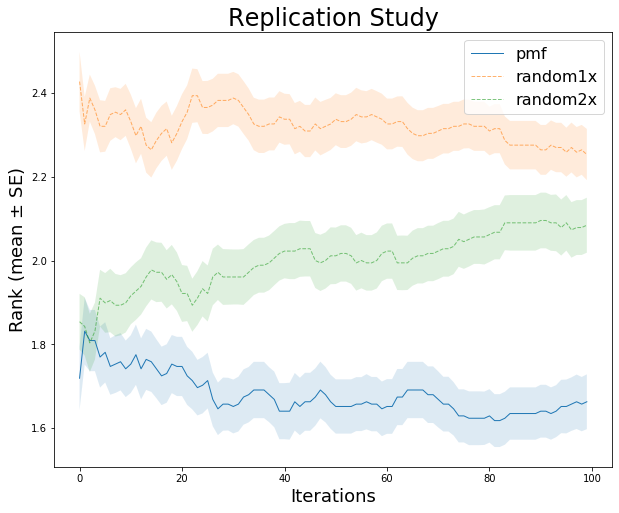

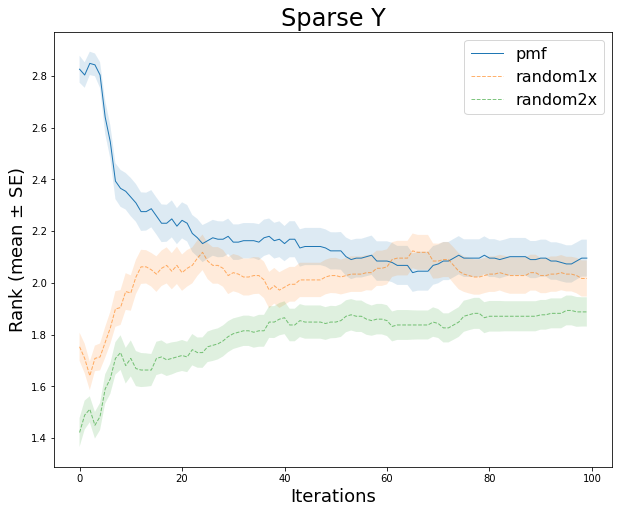

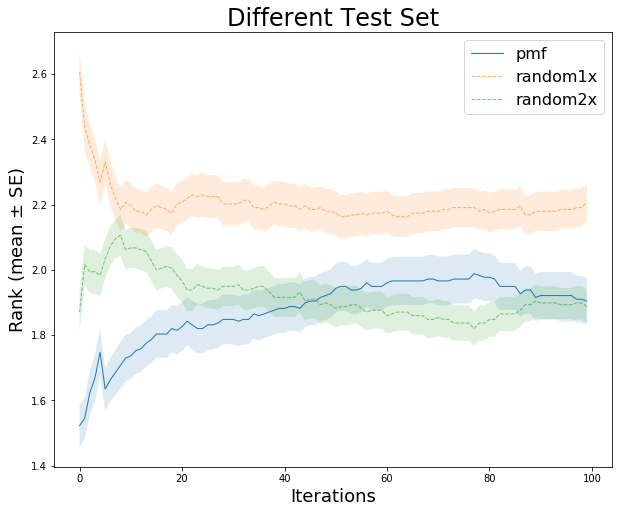

In [235]:
#compare_regrets(results);

results, _ = get_results_X('output/main')
compare_ranks(results, title='Replication Study');

results, _ = get_results_X('output/sparse')
compare_ranks(results, title='Sparse Y');

results, _ = get_results_X('output/new_test')
compare_ranks(results, title='Different Test Set');

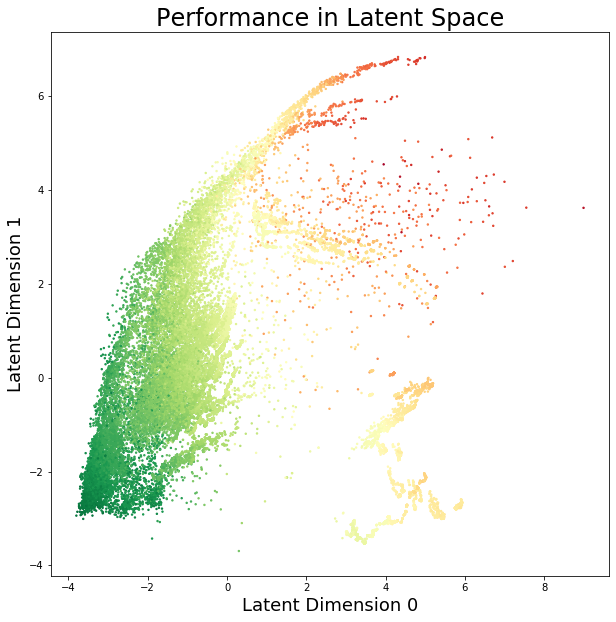

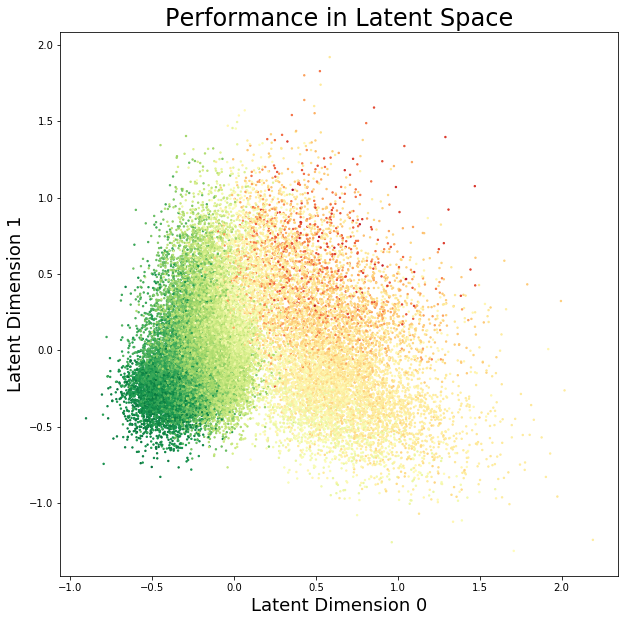

In [236]:
_, X = get_results_X('output/main')
plot_LD(X, median_performance, 0)

_, X = get_results_X('output/sparse')
plot_LD(X, median_performance, 0)